In [0]:
# to support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

#common imports
import numpy as np
import os

# to make this notebook stable across runs
def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "/tmp/09/"
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)


creating and running a graph

In [0]:
import tensorflow as tf

reset_graph()

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [65]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [66]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [0]:
sess.close()

In [0]:
with tf.Session() as sess:
  x.initializer.run()
  y.initializer.run()
  result = f.eval()

In [69]:
result

42

In [0]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
  init.run()
  result = f.eval()

In [71]:
result

42

In [0]:
init = tf.global_variables_initializer()

In [73]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)

42


In [0]:
sess.close()

In [75]:
result

42

Managing graphs

In [76]:
reset_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [77]:
graph = tf.Graph()
with graph.as_default():
  x2 = tf.Variable(2)

x2.graph is graph

True

In [78]:
x2.graph is tf.get_default_graph()

False

In [79]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
  print(y.eval())
  print(z.eval())

10
15


In [80]:
with tf.Session() as sess:
  y_val, z_val = sess.run([y, z])
  print(y_val)
  print(z_val)

10
15


Linear Regression

Using Normal Equation

In [0]:
import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

housing = fetch_california_housing()
m,n = housing.data.shape

housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype = tf.float32, name = "X")
y = tf.constant(housing.target.reshape(-1, 1), dtype = tf.float32, name = "y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
  theta_value = theta.eval()


In [82]:
theta_value

array([[-3.67372932e+01],
       [ 4.37366009e-01],
       [ 9.47520509e-03],
       [-1.08159676e-01],
       [ 6.48537397e-01],
       [-3.84734449e-06],
       [-3.79239232e-03],
       [-4.19136107e-01],
       [-4.32144403e-01]], dtype=float32)

Compare with pure NumPy



In [83]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print(theta_numpy)

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


Compare with Scikit-Learn

In [84]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


Using Batch Gradient Descent

Gradient Descent requires scaling the feature vectors first. We could do this using TF, but let's just use Scikit-Learn for now.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [86]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


Manually computing the gradients

In [87]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype = tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name ="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta-learning_rate*gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)

  for epoch in range(n_epochs):
    if epoch%100 == 0:
      print("Epoch", epoch, "MSE = ", mse.eval())
    sess.run(training_op)
  
  best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE =  9.161542
Epoch 100 MSE =  0.71450055
Epoch 200 MSE =  0.56670487
Epoch 300 MSE =  0.55557173
Epoch 400 MSE =  0.5488112
Epoch 500 MSE =  0.5436363
Epoch 600 MSE =  0.53962904
Epoch 700 MSE =  0.5365092
Epoch 800 MSE =  0.5340677
Epoch 900 MSE =  0.5321473
Best theta:
[[ 2.0685523 ]
 [ 0.8874027 ]
 [ 0.14401656]
 [-0.3477088 ]
 [ 0.36178362]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145283]
 [-0.6375278 ]]


How could you find the partial derivatives of the following function with regards to a and b?

In [0]:
def my_func(a,b):
  z = 0
  for i in range(100):
    z = a * np.cos(z + i) + z * np.sin(b-i)
  return z

In [89]:
my_func(0.2, 0.3)

-0.21253923284754914

In [0]:
reset_graph()

a = tf.Variable(0.2, name ="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
  z = a* tf.cos(z+i)+ z*tf.sin(b-i)

grads = tf.gradients(z, [a,b])
init = tf.global_variables_initializer()

Let's compute the function at a=0.2 and b=0.3, and the partial derivatives at that point with regards to  and with regards to :

In [91]:
with tf.Session() as sess:
  init.run()
  print(z.eval())
  print(sess.run(grads))

-0.21253741
[-1.1388495, 0.19671395]


Using a GradientDescentOptimizer

In [0]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype = tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(mse)

In [94]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)

  for epoch in range(n_epochs):
    if epoch % 100 == 0:
      print("Epoch", epoch, "MSE =", mse.eval())
    sess.run(training_op)

  best_theta = theta.eval()

print("Best theta:")
print(best_theta)


Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.71450055
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340677
Epoch 900 MSE = 0.5321473
Best theta:
[[ 2.0685523 ]
 [ 0.88740265]
 [ 0.14401655]
 [-0.34770873]
 [ 0.3617836 ]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614529 ]
 [-0.6375279 ]]


Using a momentum optimizer

In [0]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype =tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype = tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [0]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

In [0]:
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [98]:
with tf.Session() as sess:
  sess.run(init)

  for epoch in range(n_epochs):
    sess.run(training_op)
  
  best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Best theta:
[[ 2.068558  ]
 [ 0.8296286 ]
 [ 0.11875336]
 [-0.26554462]
 [ 0.305711  ]
 [-0.00450251]
 [-0.03932662]
 [-0.8998644 ]
 [-0.87052065]]


Feeding data to the training algorithm

Placeholder nodes

In [99]:
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A+5
with tf.Session() as sess:
  B_val_1 = B.eval(feed_dict={A: [[1,2,3]]})
  B_val_2 = B.eval(feed_dict={A: [[4,5,6], [7,8,9]]})

print(B_val_1)

[[6. 7. 8.]]


In [100]:
print(B_val_2)

[[ 9. 10. 11.]
 [12. 13. 14.]]


Mini-batch Gradient Descent

In [0]:
n_epochs = 1000
learning_rate = 0.01

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [0]:
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred-y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [0]:
n_epochs = 10

In [0]:
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [0]:
def fetch_batch(epoch, batch_index, batch_size):
  np.random.seed(epoch * n_batches + batch_index)
  indices = np.random.randint(m, size=batch_size)
  X_batch = scaled_housing_data_plus_bias[indices]
  y_batch = housing.target.reshape(-1, 1)[indices]
  return X_batch, y_batch

with tf.Session() as sess:
  sess.run(init)

  for epoch in range(n_epochs):
    for batch_index in range(n_batches):
      X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})

  best_theta = theta.eval()

In [107]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255149],
       [-0.31211886],
       [ 0.38510385],
       [ 0.00434167],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

Saving and restoring a model

In [108]:
reset_graph()

n_epochs = 1000                                                                       
learning_rate = 0.01                                                                  

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      
error = y_pred - y                                                                    
mse = tf.reduce_mean(tf.square(error), name="mse")                                    
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            
training_op = optimizer.minimize(mse)                                                 

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                                
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.71450055
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340677
Epoch 900 MSE = 0.5321473


In [109]:
best_theta

array([[ 2.0685523 ],
       [ 0.88740265],
       [ 0.14401655],
       [-0.34770873],
       [ 0.3617836 ],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614529 ],
       [-0.6375279 ]], dtype=float32)

In [110]:
with tf.Session() as sess:
  saver.restore(sess,"/tmp/my_model_final.ckpt")
  best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [111]:
np.allclose(best_theta, best_theta_restored)

True

If you want to have a saver that loads and restores theta with a different name, such as "weights"

In [0]:
saver = tf.train.Saver({"weights":theta})

By default the saver also saves the graph structure itself in a second file with the extension .meta. You can use the function tf.train.import_meta_graph() to restore the graph structure. This function loads the graph into the default graph and returns a Saver that can then be used to restore the graph state (i.e., the variable values):

In [113]:
reset_graph()
# notice that we start with an empty graph.

saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")  # this loads the graph structure
theta = tf.get_default_graph().get_tensor_by_name("theta:0") # not shown in the book

with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")  # this restores the graph's state
    best_theta_restored = theta.eval() # not shown in the book

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [114]:
np.allclose(best_theta, best_theta_restored)

True

This means that you can import a pretrained model without having to have the corresponding Python code to build the graph. This is very handy when you keep tweaking and saving your model: you can load a previously saved model without having to search for the version of the code that built it.

Visualizing the graph

Using TensorBoard

In [0]:
reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [0]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape = (None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n+1,1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [0]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [0]:
n_epochs = 10
batch_size=100
n_batches = int(np.ceil(m/batch_size))

In [0]:
with tf.Session() as sess:
  sess.run(init)

  for epoch in range(n_epochs):
    for batch_index in range(n_batches):
      X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
      if batch_index %10 == 0:
        summary_str = mse_summary.eval(feed_dict={X:X_batch, y:y_batch})
        step = epoch * n_batches+batch_index
        file_writer.add_summary(summary_str, step)
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})

  best_theta = theta.eval()

In [0]:
file_writer.close()

In [121]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255149],
       [-0.31211886],
       [ 0.38510385],
       [ 0.00434167],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

Name scopes

In [0]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X= tf.placeholder(tf.float32, shape =(None, n+1), name="X")
y=tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="prediction")

In [0]:
with tf.name_scope("loss") as scope:
  error = y_pred -y
  mse = tf.reduce_mean(tf.square(error), name="mse")

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [125]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m/batch_size))

with tf.Session() as sess:
  sess.run(init)

  for epoch in range(n_epochs):
    for batch_index in range(n_batches):
      X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
      if batch_index %10 ==0:
        summary_str = mse_summary.eval(feed_dict={X:X_batch, y:y_batch})
        step = epoch * n_epochs+batch_index
        file_writer.add_summary(summary_str, step)
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    
  best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255149]
 [-0.31211886]
 [ 0.38510385]
 [ 0.00434167]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


In [126]:
print(error.op.name)

loss/sub


In [127]:
print(mse.op.name)

loss/mse


In [128]:
reset_graph()

a1 = tf.Variable(0, name='a')
a2 = tf.Variable(0, name='a')

with tf.name_scope("param"):
  a3=tf.Variable(0, name='a')

with tf.name_scope("param"):
  a4=tf.Variable(0,name='a')

for node in (a1,a2,a3,a4):
  print(node.op.name)

a
a_1
param/a
param_1/a


Modularity

An ugly flat code:

In [0]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1=tf.Variable(tf.random_normal((n_features,1)), name="weights1")
w2=tf.Variable(tf.random_normal((n_features,1)), name="weights2")
b1=tf.Variable(0.0,name="bias1")
b2=tf.Variable(0.0, name="bias2")

z1=tf.add(tf.matmul(X,w1), b1, name="z1")
z2=tf.add(tf.matmul(X,w2), b2, name="z2")

relu1= tf.maximum(z1, 0.0, name="relu1")
relu2= tf.maximum(z2, 0.0, name="relu2")

output = tf.add(relu1, relu2, name="output")

Much better, using a function to build the ReLUs:

In [0]:
reset_graph()

def relu(X):
  w_shape = (int(X.get_shape()[1]),1)
  w = tf.Variable(tf.random_normal(w_shape), name="weights")
  b = tf.Variable(0.0, name="bias")
  z = tf.add(tf.matmul(X, w), b, name="z")
  return tf.maximum(z, 0.0, name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [0]:
file_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

Even better using name scopes:

In [0]:
reset_graph()

def relu(X):
  with tf.name_scope("relu"):
    w_shape=(int(X.get_shape()[1]),1)
    w=tf.Variable(tf.random_normal(w_shape), name="weights")
    b=tf.Variable(0.0, name="bias")
    z=tf.add(tf.matmul(X,w),b,name="z")
    return tf.maximum(z,0.0, name="relu")

In [0]:
n_features=3
X=tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())
file_writer.close()

Sharing Variables

Sharing a threshold variable the classic way, by defining it outside of the relu() function then passing it as a parameter:

In [0]:
reset_graph()

def relu(X, threshold):
  with tf.name_scope("relu"):
    w_shape = (int(X.get_shape()[1]),1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z=tf.add(tf.matmul(X,w), b, name="z")
    return tf.maximum(z, threshold, name="outputs")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus =[relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

In [0]:
reset_graph()

def relu(X):
  with tf.name_scope("relu"):
    if not hasattr(relu, "threshold"):
      relu.threshold = tf.Variable(0.0, name="threshold")
    w_shape = int(X.get_shape()[1]),1
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b= tf.Variable(0.0, name="bias")
    z= tf.add(tf.matmul(X,w), b, name="z")
    return tf.maximum(z, relu.threshold, name="max")

In [0]:
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [0]:
reset_graph()

with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

In [0]:
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

In [0]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

In [0]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          
        w = tf.Variable(tf.random_normal(w_shape), name="weights") 
        b = tf.Variable(0.0, name="bias")                           
        z = tf.add(tf.matmul(X, w), b, name="z")                   
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

In [0]:
file_writer = tf.summary.FileWriter("logs/relu6", tf.get_default_graph())
file_writer.close()

In [0]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu"):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # create the shared variable
    scope.reuse_variables()  # then reuse it
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu8", tf.get_default_graph())
file_writer.close()

In [0]:

reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  
    b = tf.Variable(0.0, name="bias")                           
    z = tf.add(tf.matmul(X, w), b, name="z")                    
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [0]:
file_writer = tf.summary.FileWriter("logs/relu9", tf.get_default_graph())
file_writer.close()

Extra material

In [149]:
reset_graph()

with tf.variable_scope("my_scope"):
  x0 = tf.get_variable("x", shape=(), initializer=tf.constant_initializer(0.0))
  x1 = tf.Variable(0.0, name="x")
  x2 = tf.Variable(0.0, name="x")

with tf.variable_scope("my_scope", reuse=True):
  x3 = tf.get_variable("x")
  x4 = tf.Variable(0.0, name="x")

with tf.variable_scope("", default_name="", reuse=True):
  x5 = tf.get_variable("my_scope/x")

print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)
print("x3:", x3.op.name)
print("x4:", x4.op.name)
print("x5:", x5.op.name)
print(x0 is x3 and x3 is x5)

x0: my_scope/x
x1: my_scope/x_1
x2: my_scope/x_2
x3: my_scope/x
x4: my_scope_1/x
x5: my_scope/x
True


Strings

In [150]:
reset_graph()

text = np.array("Do you want some cafe?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
  print(text_tensor.eval())

[b'Do' b'you' b'want' b'some' b'cafe?']


Logistic Regression with Mini-Batch Gradient Descent using TensorFlow

In [0]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

 a peek at the dataset:

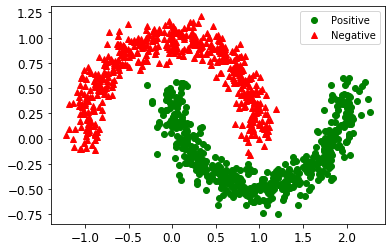

In [156]:
plt.plot(X_moons[y_moons ==1, 0], X_moons[y_moons==1,1], 'go', label="Positive")
plt.plot(X_moons[y_moons==0,0], X_moons[y_moons==0,1], 'r^', label="Negative")
plt.legend()
plt.show()

In [0]:
X_moons_with_bias = np.c_[np.ones((m,1)), X_moons]

In [159]:
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [0]:
y_moons_column_vector = y_moons.reshape(-1,1)

In [0]:
test_ratio = 0.2
test_size = int(m*test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

In [0]:
def random_batch(X_train, y_train, batch_size):
  rnd_indices = np.random.randint(0, len(X_train), batch_size)
  X_batch = X_train[rnd_indices]
  y_batch = y_train[rnd_indices]
  return X_batch, y_batch

In [164]:
X_batch , y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  1.30399966, -0.54329461],
       [ 1.        , -0.04027286,  0.15633953],
       [ 1.        ,  0.73249294, -0.40782775],
       [ 1.        , -0.7805163 ,  0.4411743 ],
       [ 1.        ,  0.60832246,  0.54703694]])

In [165]:
y_batch

array([[1],
       [1],
       [1],
       [0],
       [0]])

In [0]:
reset_graph()

In [0]:
n_inputs = 2

In [0]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs+1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = 1/(1+tf.exp(-logits))

In [0]:
y_proba = tf.sigmoid(logits)

In [0]:
epsilon = 1e-7
loss = -tf.reduce_mean(y*tf.log(y_proba+epsilon)+(1-y)*tf.log(1-y_proba+epsilon))

In [171]:
loss = tf.losses.log_loss(y, y_proba)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

In [175]:
n_epochs  = 1000
batch_size = 50
n_batches = int(np.ceil(m/batch_size))

with tf.Session() as sess:
  sess.run(init)

  for epoch in range(n_epochs):
    for batch_index in range(n_batches):
      X_batch, y_batch = random_batch(X_train, y_train, batch_size)
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    loss_val = loss.eval({X:X_test, y:y_test})
    if epoch%100==0:
      print("epoch:",epoch,"loss:",loss_val)
  y_proba = y_proba.eval(feed_dict={X:X_test,y:y_test})

epoch: 0 loss: 0.7926023
epoch: 100 loss: 0.34346348
epoch: 200 loss: 0.3075404
epoch: 300 loss: 0.2928889
epoch: 400 loss: 0.28533572
epoch: 500 loss: 0.28047806
epoch: 600 loss: 0.27808294
epoch: 700 loss: 0.27615443
epoch: 800 loss: 0.27551997
epoch: 900 loss: 0.2749123


In [176]:
y_proba[:5]

array([[0.54895616],
       [0.70724374],
       [0.51900256],
       [0.9911136 ],
       [0.5085905 ]], dtype=float32)

In [177]:
y_pred = (y_proba>=0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [178]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.8627450980392157

In [180]:
recall_score(y_test, y_pred)

0.8888888888888888

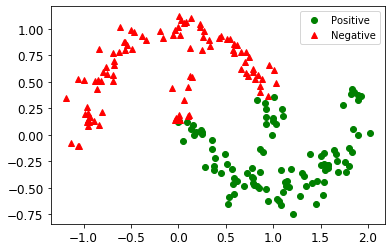

In [181]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Now let's start over, but this time we will add all the bells and whistles, as listed in the exercise:

Define the graph within a logistic_regression() function that can be reused easily.

Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.
Restore the last checkpoint upon startup if training was interrupted.

Define the graph using nice scopes so the graph looks good in TensorBoard.

Add summaries to visualize the learning curves in TensorBoard.

Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.




Before we start, we will add 4 more features to the inputs: , ,  and . This was not part of the exercise, but it will demonstrate how adding features can improve the model. We will do this manually, but you could also add them using sklearn.preprocessing.PolynomialFeatures.

In [0]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [184]:
X_train_enhanced[:5]

array([[ 1.00000000e+00, -5.14696757e-02,  4.44198631e-01,
         2.64912752e-03,  1.97312424e-01, -1.36349734e-04,
         8.76459084e-02],
       [ 1.00000000e+00,  1.03201691e+00, -4.19741157e-01,
         1.06505890e+00,  1.76182639e-01,  1.09915879e+00,
        -7.39511049e-02],
       [ 1.00000000e+00,  8.67891864e-01, -2.54827114e-01,
         7.53236288e-01,  6.49368582e-02,  6.53727646e-01,
        -1.65476722e-02],
       [ 1.00000000e+00,  2.88850997e-01, -4.48668621e-01,
         8.34348982e-02,  2.01303531e-01,  2.41002535e-02,
        -9.03185778e-02],
       [ 1.00000000e+00, -8.33439108e-01,  5.35056649e-01,
         6.94620746e-01,  2.86285618e-01, -5.78924095e-01,
         1.53179024e-01]])

In [0]:
reset_graph()

In [0]:
def logistic_regression(X,y,initializer=None, seed=42, learning_rate=0.01):
  n_inputs_including_bias = int(X.get_shape()[1])
  with tf.name_scope("logistic_regression"):
    with tf.name_scope("model"):
      if initializer is None:
        initializer = tf.random_uniform([n_inputs_including_bias,1], -1.0, 1.0, seed=seed)
        theta = tf.Variable(initializer, name="theta")
        logits = tf.matmul(X, theta, name="logits")
        y_proba = tf.sigmoid(logits)
    with tf.name_scope("train"):
      loss = tf.losses.log_loss(y,y_proba, scope="loss")
      optimizer= tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
      training_op = optimizer.minimize(loss)
      loss_summary = tf.summary.scalar('log_loss', loss)
    with tf.name_scope("init"):
      init = tf.global_variables_initializer()
    with tf.name_scope("save"):
      saver = tf.train.Saver()

  return y_proba, loss, training_op, loss_summary, init, saver


unction to get the name of the log directory to save the summaries for Tensorboard:

In [0]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [0]:

n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [194]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.629985
Epoch: 500 	Loss: 0.16122366
Epoch: 1000 	Loss: 0.119032115
Epoch: 1500 	Loss: 0.09732921
Epoch: 2000 	Loss: 0.08369793
Epoch: 2500 	Loss: 0.07437582
Epoch: 3000 	Loss: 0.06750215
Epoch: 3500 	Loss: 0.062206887
Epoch: 4000 	Loss: 0.058026776
Epoch: 4500 	Loss: 0.054562964
Epoch: 5000 	Loss: 0.05170827
Epoch: 5500 	Loss: 0.049237728
Epoch: 6000 	Loss: 0.04716729
Epoch: 6500 	Loss: 0.045376644
Epoch: 7000 	Loss: 0.043818757
Epoch: 7500 	Loss: 0.04237423
Epoch: 8000 	Loss: 0.041089173
Epoch: 8500 	Loss: 0.039970923
Epoch: 9000 	Loss: 0.038920242
Epoch: 9500 	Loss: 0.038010746
Epoch: 10000 	Loss: 0.037155695


In [0]:
y_pred = (y_proba_val >= 0.5)

In [202]:
precision_score(y_test, y_pred)

0.9797979797979798

In [203]:
recall_score(y_test, y_pred)

0.9797979797979798

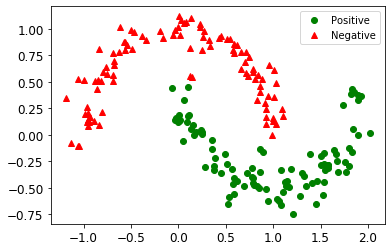

In [204]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

implementation of a randomized search on both the batch size and the learning rate

In [205]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

Iteration 0
  logdir: tf_logs/logreg-run-20191219132154/
  batch size: 54
  learning_rate: 0.004430375245218265
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 1
  logdir: tf_logs/logreg-run-20191219132405/
  batch size: 22
  learning_rate: 0.0017826497151386947
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 2
  logdir: tf_logs/logreg-run-20191219132852/
  batch size: 74
  learning_rate: 0.00203228544324115
  training: .....................
  precision: 0.9696969696969697
  recall: 0.9696969696969697
Iteration 3
  logdir: tf_logs/logreg-run-20191219133031/
  batch size: 58
  learning_rate: 0.004491523825137997
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 4
  logdir: tf_logs/logreg-run-20191219133235/
  batch size: 61
  learning_rate: 0.07963234721775589
  training: .....................
  precision: 0.980198019801